# Image Data & CNNs

In [1]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
IMAGE_SIZE = (224, 224)

## Import Data

In [3]:
def load_data(path:str):
  x = []
  for folder in os.listdir(path):
      dataset_path = path + "/" + folder
      for img in os.listdir(dataset_path):
          img_arr = cv2.imread(dataset_path + "/" + img)
          img_arr=cv2.resize(img_arr,(224,224))
          x.append(img_arr)

  x = np.array(x)
  x = x / 255.0

  datagen = ImageDataGenerator(rescale = 1./255)

  dataset = datagen.flow_from_directory(path,
                                        target_size=IMAGE_SIZE,
                                        batch_size= 15,
                                        class_mode='sparse')

  y = dataset.classes

  return x, y

In [4]:
active_dir = "Cats-and-Chickens/"

train_path = active_dir + "train"
test_path = active_dir + "test"
val_path = active_dir + "val"

x_train, y_train = load_data(train_path)
x_test, y_test = load_data(test_path)
x_val, y_val = load_data(val_path)

Found 1083 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


## Adding Pre-trained Model

In [5]:
vgg = VGG19(input_shape=list(IMAGE_SIZE) + [3],
            weights='imagenet',
            include_top=False)
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

2024-04-18 13:04:23.753427: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-18 13:04:23.753468: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-18 13:04:23.753473: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-18 13:04:23.754243: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 13:04:23.754663: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(2,
                   activation='sigmoid')(x)

model = Model(inputs=vgg.input,
              outputs=prediction)

In [7]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Model Training

In [8]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [9]:
#Early stopping to avoid overfitting of model
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',
                         mode='min',
                         verbose=1,
                         patience=5)

# fit the model
history = model.fit(
  x_train,
  y_train,
  validation_data=(x_val,y_val),
  epochs=5,
  callbacks=[early_stop],
  batch_size=20,
  shuffle=True)

Epoch 1/5


2024-04-18 13:04:26.113615: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-18 13:04:26.521875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 0.3644 - accuracy: 0.8578

2024-04-18 13:04:48.683413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 25s 430ms/step - loss: 0.3644 - accuracy: 0.8578 - val_loss: 0.3571 - val_accuracy: 0.8283
Epoch 2/5
55/55 [==============================] - 22s 407ms/step - loss: 0.0225 - accuracy: 0.9945 - val_loss: 0.2147 - val_accuracy: 0.8889
Epoch 3/5
55/55 [==============================] - 24s 440ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.2233 - val_accuracy: 0.8889
Epoch 4/5
55/55 [==============================] - 28s 514ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.2393 - val_accuracy: 0.8889
Epoch 5/5
55/55 [==============================] - 28s 516ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.2218 - val_accuracy: 0.8889


## Model Evaluation

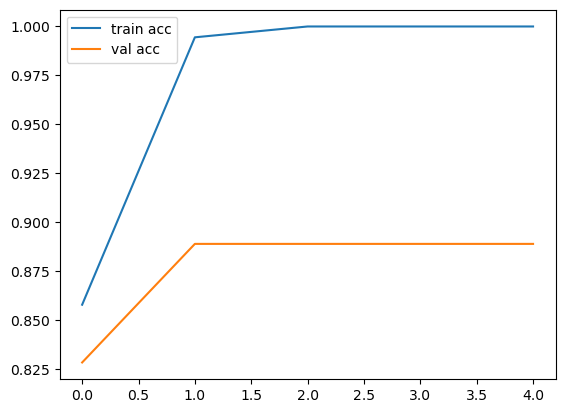

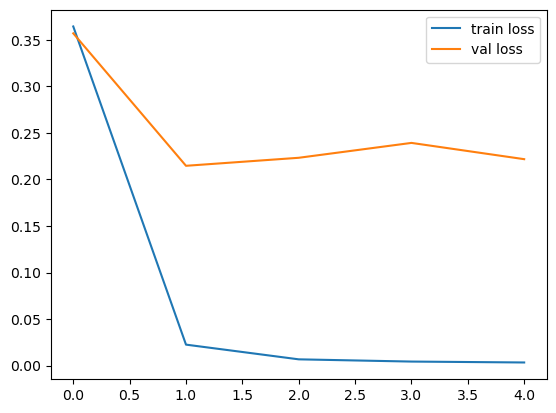

In [10]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.close()

# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [11]:
model.evaluate(x_test,
               y_test,
               batch_size=2)

#predict
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)

37/37 [==============================] - 5s 127ms/step - loss: 0.1036 - accuracy: 0.9315


2024-04-18 13:06:40.849369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 592ms/step


In [12]:
#get classification report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89        21
           1       1.00      0.90      0.95        52

    accuracy                           0.93        73
   macro avg       0.90      0.95      0.92        73
weighted avg       0.94      0.93      0.93        73

